<a href="https://colab.research.google.com/github/Abdul-Qadeerr/machine-learning/blob/main/housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Cell 1: Install required packages (if needed)
# !pip install pandas numpy matplotlib seaborn scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [17]:
# Cell 2: Data Loading/Generation
def create_sample_data(n_samples=1000):
    """
    Create synthetic housing data for demonstration
    In real scenario, load your own dataset
    """
    np.random.seed(42)

    data = {
        'area': np.random.normal(1500, 500, n_samples).astype(int),
        'bedrooms': np.random.randint(1, 6, n_samples),
        'bathrooms': np.random.randint(1, 4, n_samples),
        'stories': np.random.randint(1, 4, n_samples),
        'parking': np.random.randint(0, 3, n_samples),
        'year_built': np.random.randint(1950, 2020, n_samples),
        'location': np.random.choice(['Urban', 'Suburban', 'Rural'], n_samples),
        'mainroad': np.random.choice(['Yes', 'No'], n_samples),
        'guestroom': np.random.choice(['Yes', 'No'], n_samples),
        'basement': np.random.choice(['Yes', 'No'], n_samples),
        'furnishingstatus': np.random.choice(['Furnished', 'Semi-Furnished', 'Unfurnished'], n_samples),
    }

    df = pd.DataFrame(data)

    # Create price based on features with some noise
    base_price = (
        df['area'] * 100 +
        df['bedrooms'] * 50000 +
        df['bathrooms'] * 30000 +
        df['stories'] * 40000 +
        df['parking'] * 20000 +
        (df['year_built'] - 1950) * 1000
    )

    # Add location premium
    location_factor = df['location'].map({'Urban': 1.5, 'Suburban': 1.2, 'Rural': 1.0})
    base_price = base_price * location_factor

    # Add feature premiums
    base_price += df['mainroad'].map({'Yes': 20000, 'No': 0})
    base_price += df['guestroom'].map({'Yes': 15000, 'No': 0})
    base_price += df['basement'].map({'Yes': 25000, 'No': 0})
    base_price += df['furnishingstatus'].map({'Furnished': 30000, 'Semi-Furnished': 15000, 'Unfurnished': 0})

    # Add some noise
    noise = np.random.normal(0, 50000, n_samples)
    df['price'] = base_price + noise
    df['price'] = df['price'].astype(int)

    return df

# Load or create dataset
print("📊 Loading/Creating dataset...")
df = create_sample_data(1000)
print(f"Dataset shape: {df.shape}")

📊 Loading/Creating dataset...
Dataset shape: (1000, 12)


In [18]:
# Cell 3: Data Overview
print("="*60)
print("DATA OVERVIEW")
print("="*60)

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Dataset info
print("\n📋 Dataset Information:")
print(df.info())

# Statistical summary
print("\n📈 Statistical Summary:")
display(df.describe())

# Check for missing values
print("\n🔍 Missing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

if missing_data.sum() == 0:
    print("✅ No missing values found!")

DATA OVERVIEW

First 5 rows:


,area,bedrooms,bathrooms,stories,parking,year_built,location,mainroad,guestroom,basement,furnishingstatus,price
0,1748,4,3,2,1,2009,Urban,No,No,No,Furnished,1022475
1,1430,1,3,1,1,2015,Rural,Yes,Yes,Yes,Furnished,507079
2,1823,3,1,2,2,2014,Rural,No,No,No,Unfurnished,444680
3,2261,5,3,2,1,2000,Urban,No,Yes,No,Unfurnished,1029529
4,1382,3,3,3,1,1985,Suburban,No,Yes,No,Unfurnished,629596



📋 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   area              1000 non-null   int64 
 1   bedrooms          1000 non-null   int64 
 2   bathrooms         1000 non-null   int64 
 3   stories           1000 non-null   int64 
 4   parking           1000 non-null   int64 
 5   year_built        1000 non-null   int64 
 6   location          1000 non-null   object
 7   mainroad          1000 non-null   object
 8   guestroom         1000 non-null   object
 9   basement          1000 non-null   object
 10  furnishingstatus  1000 non-null   object
 11  price             1000 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 93.9+ KB
None

📈 Statistical Summary:


,area,bedrooms,bathrooms,stories,parking,year_built,price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,1509.163000,3.045000,1.985000,1.988000,1.035000,1984.824000,6.624611e+05
std,489.599001,1.424431,0.835148,0.822516,0.812672,19.934403,1.729654e+05
min,-120.000000,1.000000,1.000000,1.000000,0.000000,1950.000000,2.442310e+05
25%,1175.500000,2.000000,1.000000,1.000000,0.000000,1968.000000,5.308680e+05
50%,1512.500000,3.000000,2.000000,2.000000,1.000000,1985.000000,6.495865e+05
75%,1823.250000,4.000000,3.000000,3.000000,2.000000,2002.000000,7.744212e+05
max,3426.000000,5.000000,3.000000,3.000000,2.000000,2019.000000,1.213169e+06



🔍 Missing Values:
Series([], dtype: int64)
✅ No missing values found!


EXPLORATORY DATA ANALYSIS (EDA)


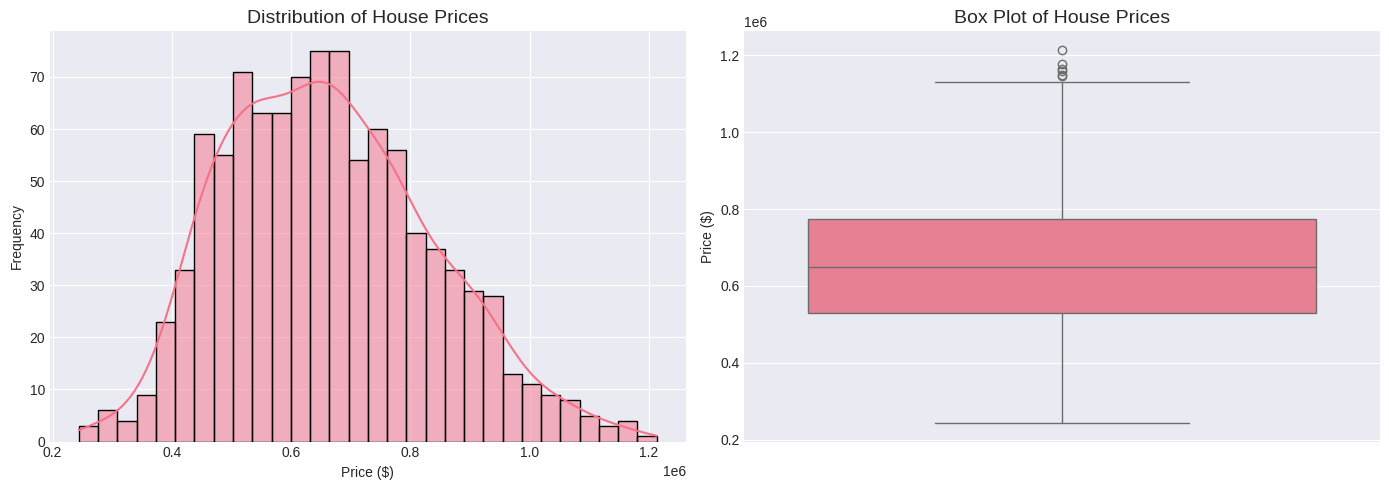

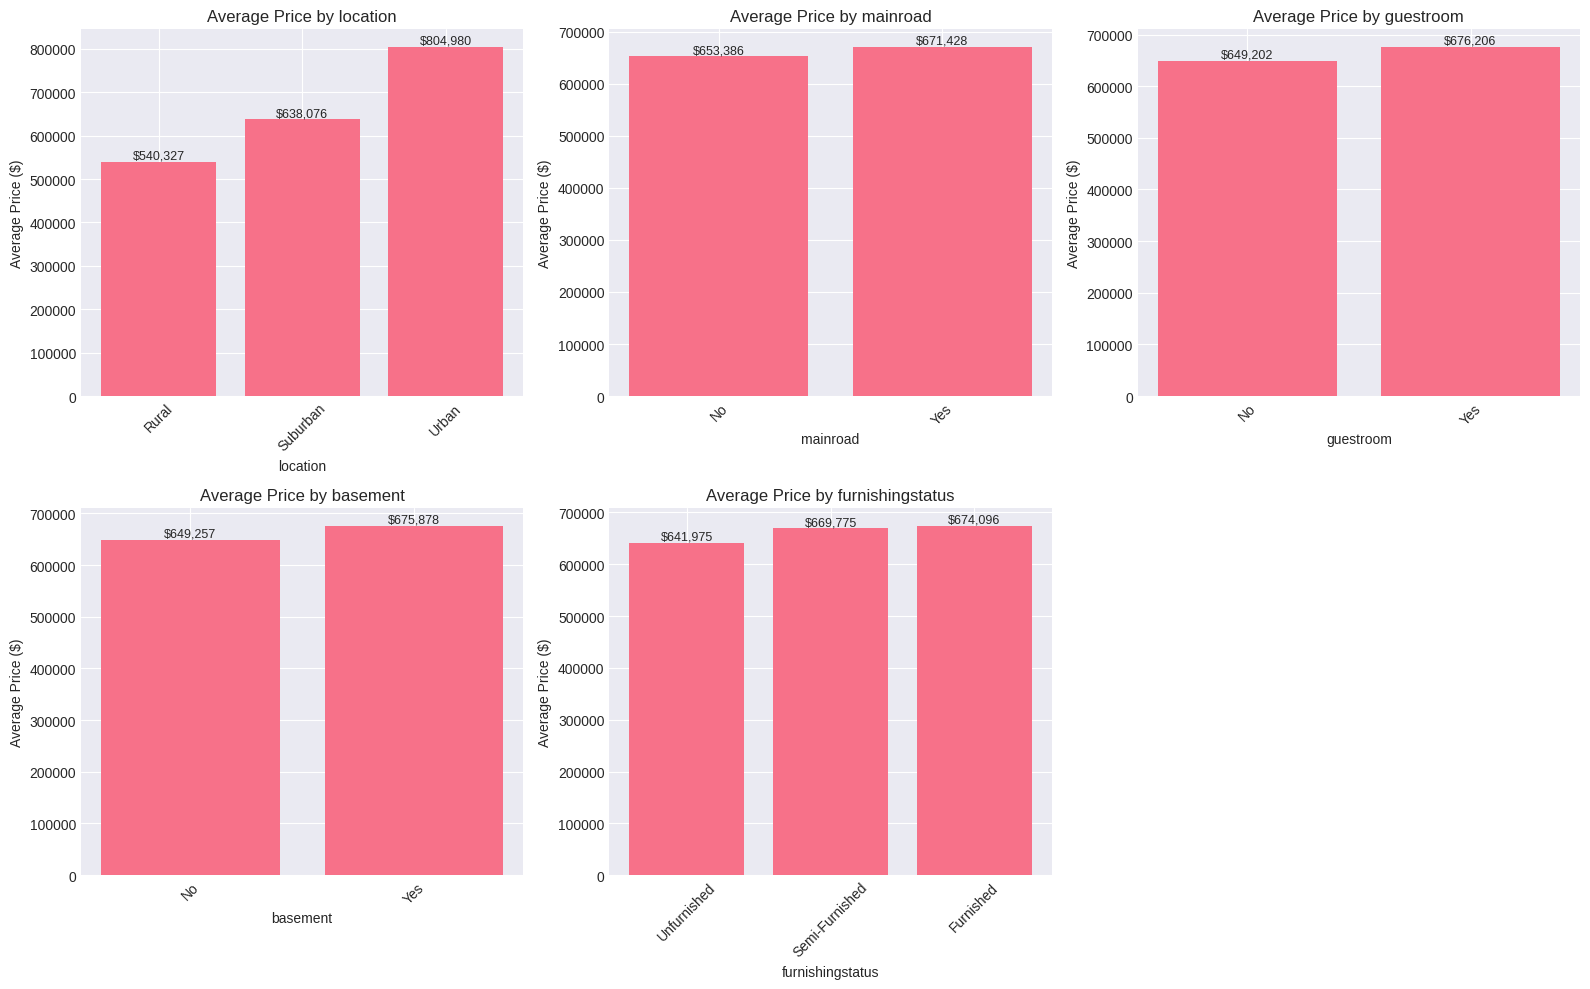

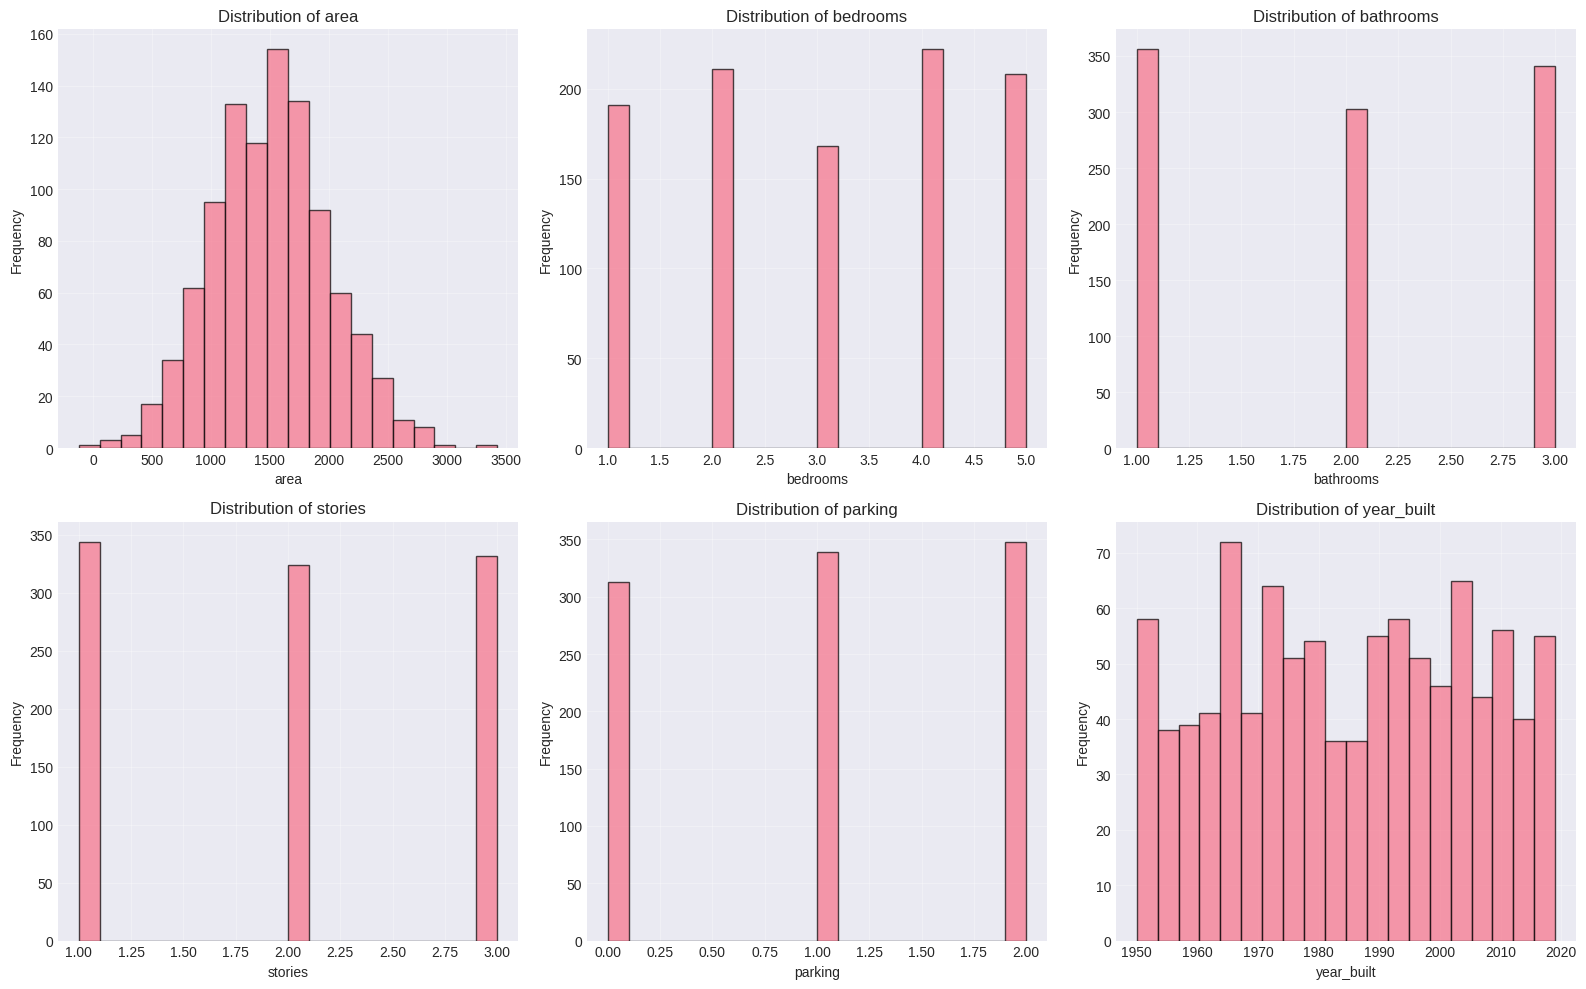

In [19]:
# Cell 4: Exploratory Data Analysis (EDA)
print("="*60)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)

# 4.1 Price Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with KDE
sns.histplot(data=df, x='price', kde=True, ax=axes[0], bins=30)
axes[0].set_title('Distribution of House Prices', fontsize=14)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(data=df, y='price', ax=axes[1])
axes[1].set_title('Box Plot of House Prices', fontsize=14)
axes[1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

# 4.2 Categorical Features Analysis
categorical_features = ['location', 'mainroad', 'guestroom', 'basement', 'furnishingstatus']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if idx < len(axes):
        # Bar plot with average price
        avg_price = df.groupby(feature)['price'].mean().sort_values()
        axes[idx].bar(range(len(avg_price)), avg_price.values)
        axes[idx].set_xticks(range(len(avg_price)))
        axes[idx].set_xticklabels(avg_price.index, rotation=45)
        axes[idx].set_title(f'Average Price by {feature}', fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Average Price ($)')

        # Add value labels
        for i, v in enumerate(avg_price.values):
            axes[idx].text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontsize=9)

# Hide unused subplot
if len(categorical_features) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

# 4.3 Numerical Features Distribution
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'year_built']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    if idx < len(axes):
        # Histogram
        axes[idx].hist(df[feature], bins=20, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {feature}', fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

CORRELATION ANALYSIS


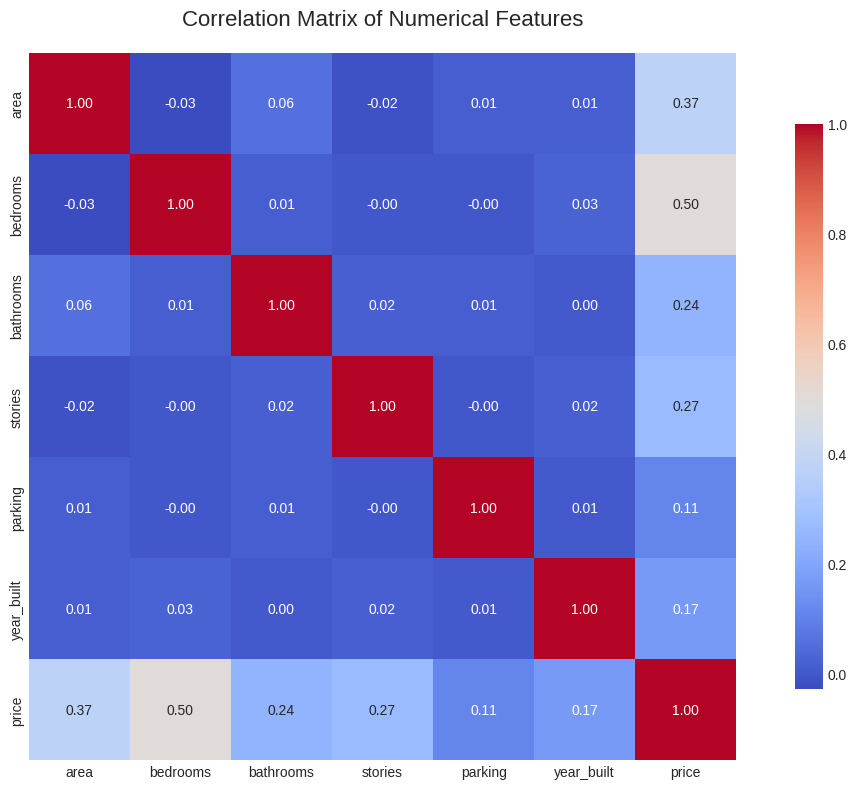


📊 Correlation with Price:
bedrooms             : +0.5012
area                 : +0.3716
stories              : +0.2680
bathrooms            : +0.2434
year_built           : +0.1655
parking              : +0.1107


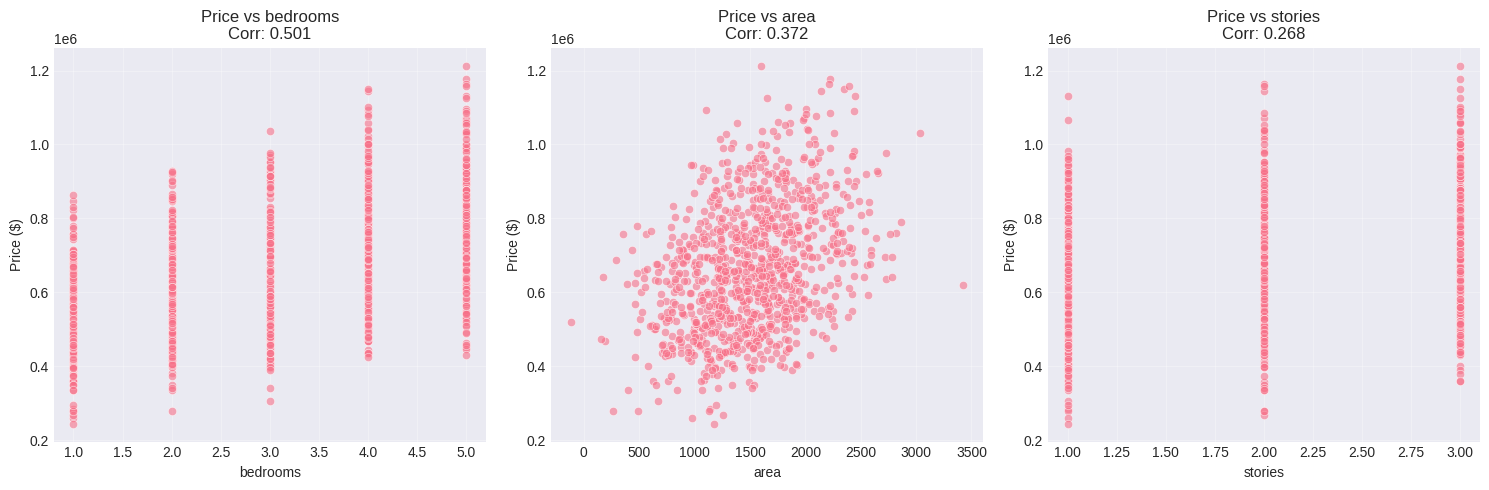

In [20]:
# Cell 5: Correlation Analysis
print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Select numerical columns for correlation
numerical_df = df.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Price correlation with other features
price_corr = corr_matrix['price'].sort_values(ascending=False)
print("\n📊 Correlation with Price:")
for feature, corr_value in price_corr.items():
    if feature != 'price':
        print(f"{feature:20} : {corr_value:+.4f}")

# Scatter plots for top correlated features
top_features = price_corr.index[1:4]  # Top 3 features excluding price itself

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, feature in enumerate(top_features):
    axes[idx].scatter(df[feature], df['price'], alpha=0.6, edgecolors='w', linewidth=0.5)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Price ($)')
    axes[idx].set_title(f'Price vs {feature}\nCorr: {corr_matrix.loc["price", feature]:.3f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Cell 6: Data Preprocessing
print("="*60)
print("DATA PREPROCESSING")
print("="*60)

# Create a copy of the dataframe
df_processed = df.copy()

# 6.1 Encode categorical variables
categorical_cols = ['location', 'mainroad', 'guestroom', 'basement', 'furnishingstatus']
label_encoders = {}

print("🔤 Encoding categorical variables:")
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"  {col:20} → {list(le.classes_)}")

# 6.2 Split features and target
X = df_processed.drop('price', axis=1)
y = df_processed['price']

print(f"\n📐 Feature matrix shape: {X.shape}")
print(f"🎯 Target vector shape: {y.shape}")

# 6.3 Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n📊 Data Split:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# 6.4 Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data preprocessing completed!")
print(f"  Scaled training set shape: {X_train_scaled.shape}")
print(f"  Scaled test set shape:     {X_test_scaled.shape}")

DATA PREPROCESSING
🔤 Encoding categorical variables:
  location             → ['Rural', 'Suburban', 'Urban']
  mainroad             → ['No', 'Yes']
  guestroom            → ['No', 'Yes']
  basement             → ['No', 'Yes']
  furnishingstatus     → ['Furnished', 'Semi-Furnished', 'Unfurnished']

📐 Feature matrix shape: (1000, 11)
🎯 Target vector shape: (1000,)

📊 Data Split:
  Training set: 800 samples (80.0%)
  Test set:     200 samples (20.0%)

✅ Data preprocessing completed!
  Scaled training set shape: (800, 11)
  Scaled test set shape:     (200, 11)


In [22]:
# Cell 7: Model Building
print("="*60)
print("MODEL BUILDING")
print("="*60)

# Define models to train
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf', C=100, gamma=0.1)
}

# Dictionary to store results
results = {}

print("🚀 Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                 cv=5, scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Store results
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'cv_scores': cv_scores
    }

    print(f"  ✓ Test R²: {test_r2:.4f}, Test RMSE: ${test_rmse:,.2f}")
    print(f"    CV R²: {cv_mean:.4f} (±{cv_std:.4f})")
    print()

print("✅ All models trained successfully!")

MODEL BUILDING
🚀 Training models...

Training Linear Regression...
  ✓ Test R²: 0.9051, Test RMSE: $51,714.59
    CV R²: 0.8981 (±0.0089)

Training Ridge Regression...
  ✓ Test R²: 0.9051, Test RMSE: $51,723.56
    CV R²: 0.8981 (±0.0089)

Training Lasso Regression...
  ✓ Test R²: 0.9051, Test RMSE: $51,714.59
    CV R²: 0.8981 (±0.0089)

Training Decision Tree...
  ✓ Test R²: 0.6630, Test RMSE: $97,477.52
    CV R²: 0.6937 (±0.0146)

Training Random Forest...
  ✓ Test R²: 0.8378, Test RMSE: $67,625.37
    CV R²: 0.8194 (±0.0188)

Training Gradient Boosting...
  ✓ Test R²: 0.8903, Test RMSE: $55,621.63
    CV R²: 0.8763 (±0.0094)

Training Support Vector Regressor...
  ✓ Test R²: 0.0153, Test RMSE: $166,613.79
    CV R²: 0.0031 (±0.0148)

✅ All models trained successfully!


In [23]:
# Cell 8: Model Comparison
print("="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Test R²': metrics['test_r2'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae'],
        'Train R²': metrics['train_r2'],
        'CV R² Mean': metrics['cv_mean'],
        'CV R² Std': metrics['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("\n📊 Model Performance Comparison (sorted by Test R²):")
display(comparison_df.style\
    .background_gradient(subset=['Test R²', 'CV R² Mean'], cmap='YlOrBr')\
    .format({
        'Test R²': '{:.4f}',
        'Test RMSE': '${:,.2f}',
        'Test MAE': '${:,.2f}',
        'Train R²': '{:.4f}',
        'CV R² Mean': '{:.4f}',
        'CV R² Std': '{:.4f}'
    }))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_metrics = results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R² Score: {best_model_metrics['test_r2']:.4f}")
print(f"   Test RMSE: ${best_model_metrics['test_rmse']:,.2f}")
print(f"   Cross-Validation R²: {best_model_metrics['cv_mean']:.4f} (±{best_model_metrics['cv_std']:.4f})")

MODEL COMPARISON

📊 Model Performance Comparison (sorted by Test R²):


,Model,Test R²,Test RMSE,Test MAE,Train R²,CV R² Mean,CV R² Std
2,Lasso Regression,0.9051,"$51,714.59","$41,807.49",0.9022,0.8981,0.0089
0,Linear Regression,0.9051,"$51,714.59","$41,807.49",0.9022,0.8981,0.0089
1,Ridge Regression,0.9051,"$51,723.56","$41,811.54",0.9022,0.8981,0.0089
5,Gradient Boosting,0.8903,"$55,621.63","$44,175.53",0.9461,0.8763,0.0094
4,Random Forest,0.8378,"$67,625.37","$54,458.70",0.9763,0.8194,0.0188
3,Decision Tree,0.6630,"$97,477.52","$79,055.87",0.7961,0.6937,0.0146
6,Support Vector Regressor,0.0153,"$166,613.79","$135,629.49",0.0138,0.0031,0.0148



🏆 Best Model: Lasso Regression
   Test R² Score: 0.9051
   Test RMSE: $51,714.59
   Cross-Validation R²: 0.8981 (±0.0089)


MODEL PERFORMANCE VISUALIZATION


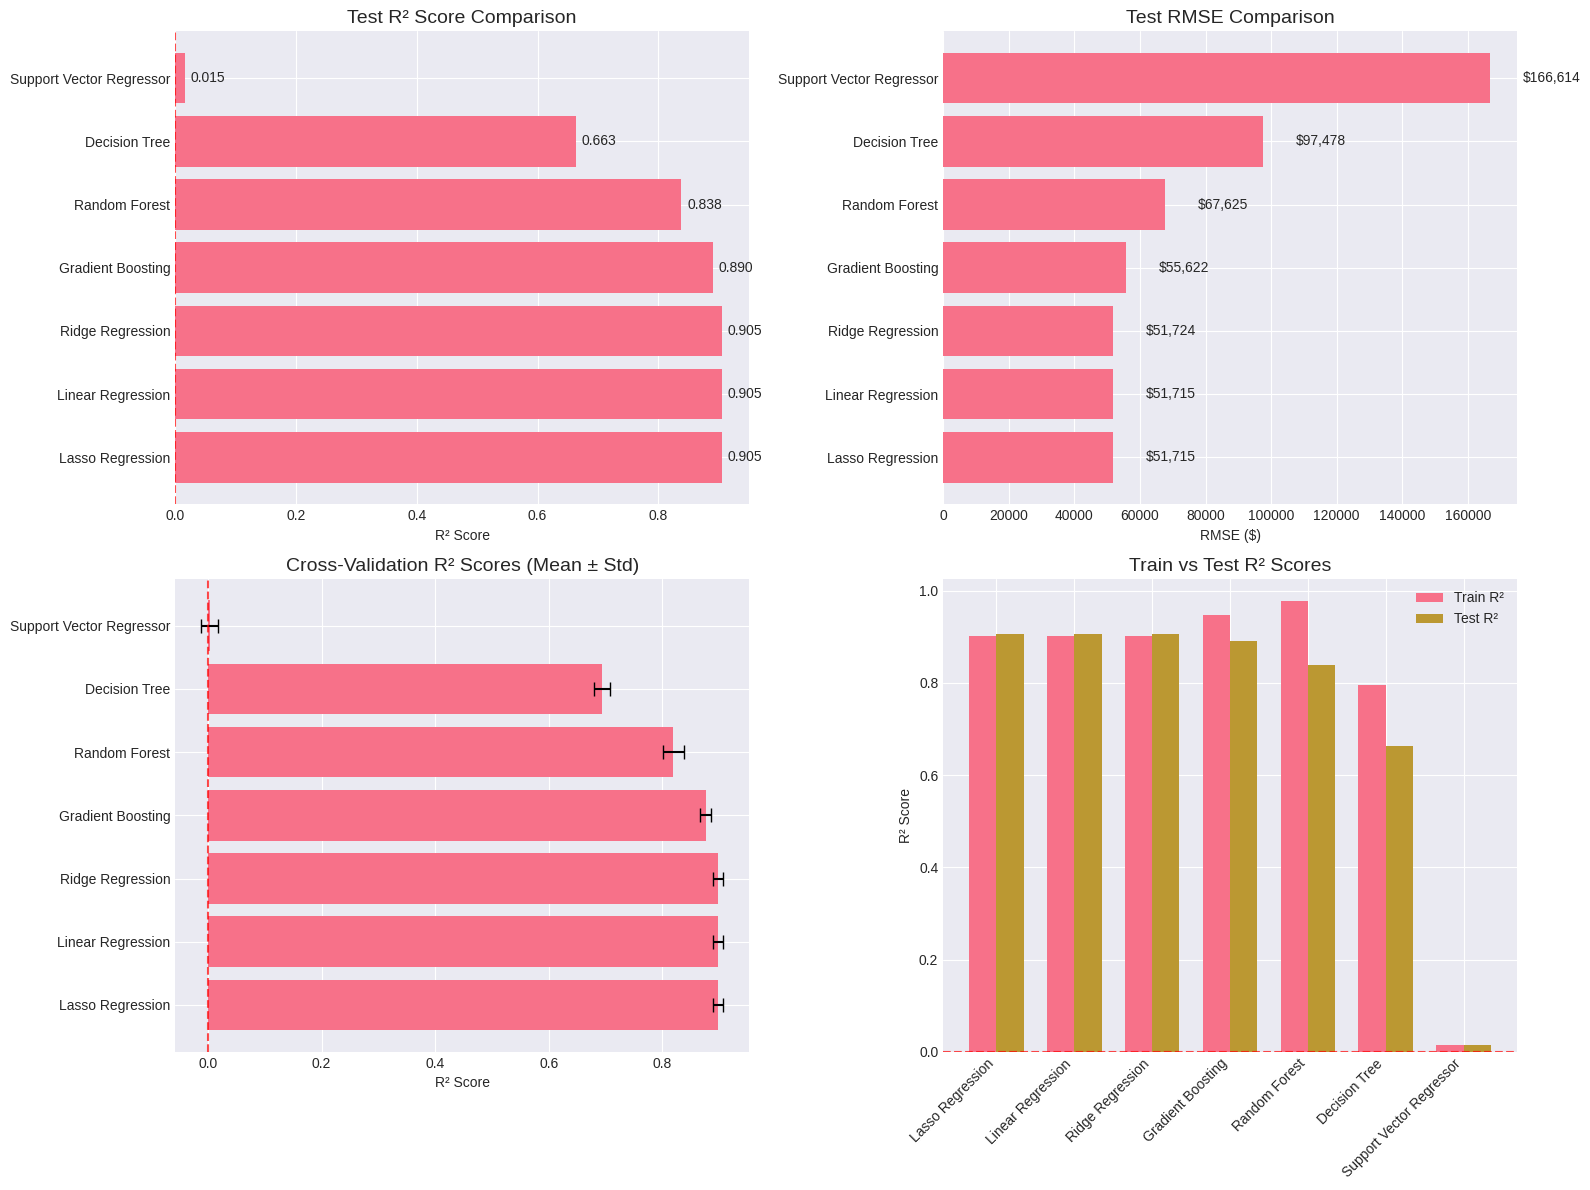

In [24]:
# Cell 9: Visualize Model Performance
print("="*60)
print("MODEL PERFORMANCE VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 9.1 Test R² Comparison
axes[0, 0].barh(range(len(comparison_df)), comparison_df['Test R²'])
axes[0, 0].set_yticks(range(len(comparison_df)))
axes[0, 0].set_yticklabels(comparison_df['Model'])
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Test R² Score Comparison', fontsize=14)
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(comparison_df['Test R²']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

# 9.2 Test RMSE Comparison
axes[0, 1].barh(range(len(comparison_df)), comparison_df['Test RMSE'])
axes[0, 1].set_yticks(range(len(comparison_df)))
axes[0, 1].set_yticklabels(comparison_df['Model'])
axes[0, 1].set_xlabel('RMSE ($)')
axes[0, 1].set_title('Test RMSE Comparison', fontsize=14)

# Add value labels
for i, v in enumerate(comparison_df['Test RMSE']):
    axes[0, 1].text(v + 10000, i, f'${v:,.0f}', va='center', fontsize=10)

# 9.3 Cross-Validation Scores
axes[1, 0].barh(range(len(comparison_df)), comparison_df['CV R² Mean'],
                xerr=comparison_df['CV R² Std'], capsize=5)
axes[1, 0].set_yticks(range(len(comparison_df)))
axes[1, 0].set_yticklabels(comparison_df['Model'])
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Cross-Validation R² Scores (Mean ± Std)', fontsize=14)
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 9.4 Train vs Test R²
x = range(len(comparison_df))
width = 0.35
axes[1, 1].bar([i - width/2 for i in x], comparison_df['Train R²'], width, label='Train R²')
axes[1, 1].bar([i + width/2 for i in x], comparison_df['Test R²'], width, label='Test R²')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Train vs Test R² Scores', fontsize=14)
axes[1, 1].legend()
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS

Analyzing feature importance for: Lasso Regression

🔍 Feature Coefficients:
             Feature    Coefficient
6           location  100521.793779
1           bedrooms   87226.936694
0               area   61709.386210
3            stories   42122.821107
2          bathrooms   27243.381222
5         year_built   26032.364775
4            parking   20589.479654
9           basement   15837.310209
10  furnishingstatus  -13904.247690
7           mainroad   11267.389260
8          guestroom    6537.556900


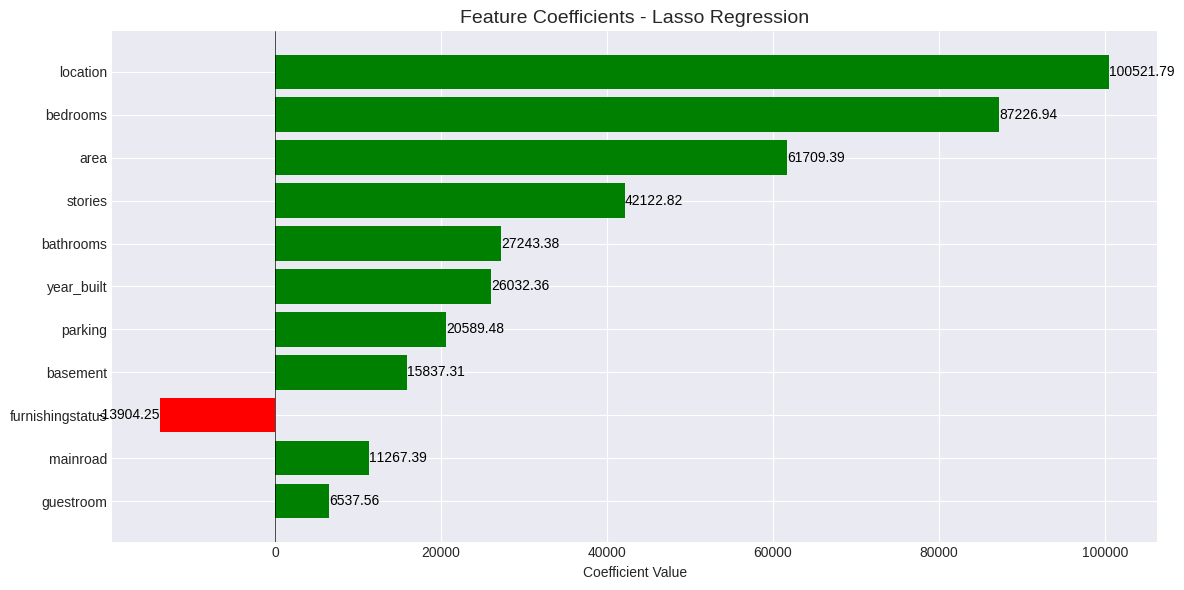

In [25]:
# Cell 10: SIMPLER VERSION - Feature Importance Analysis
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get best model
best_model = results[best_model_name]['model']
feature_names = X.columns.tolist()

print(f"\nAnalyzing feature importance for: {best_model_name}")

if hasattr(best_model, 'coef_'):
    # For Lasso Regression (or any linear model)
    coefficients = best_model.coef_
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values('Coefficient', key=abs, ascending=False)

    print("\n🔍 Feature Coefficients:")
    print(coef_df.to_string())

    # Plot coefficients
    plt.figure(figsize=(12, 6))

    # Color bars based on coefficient value
    colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]

    bars = plt.barh(range(len(coef_df)), coef_df['Coefficient'], color=colors)
    plt.yticks(range(len(coef_df)), coef_df['Feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Coefficients - {best_model_name}', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.gca().invert_yaxis()

    # Add value labels
    for i, v in enumerate(coef_df['Coefficient']):
        plt.text(v + (0.01 if v >= 0 else -0.01), i,
                 f'{v:.2f}',
                 va='center',
                 ha='left' if v >= 0 else 'right',
                 color='black')

    plt.tight_layout()
    plt.show()

PREDICTION VISUALIZATION


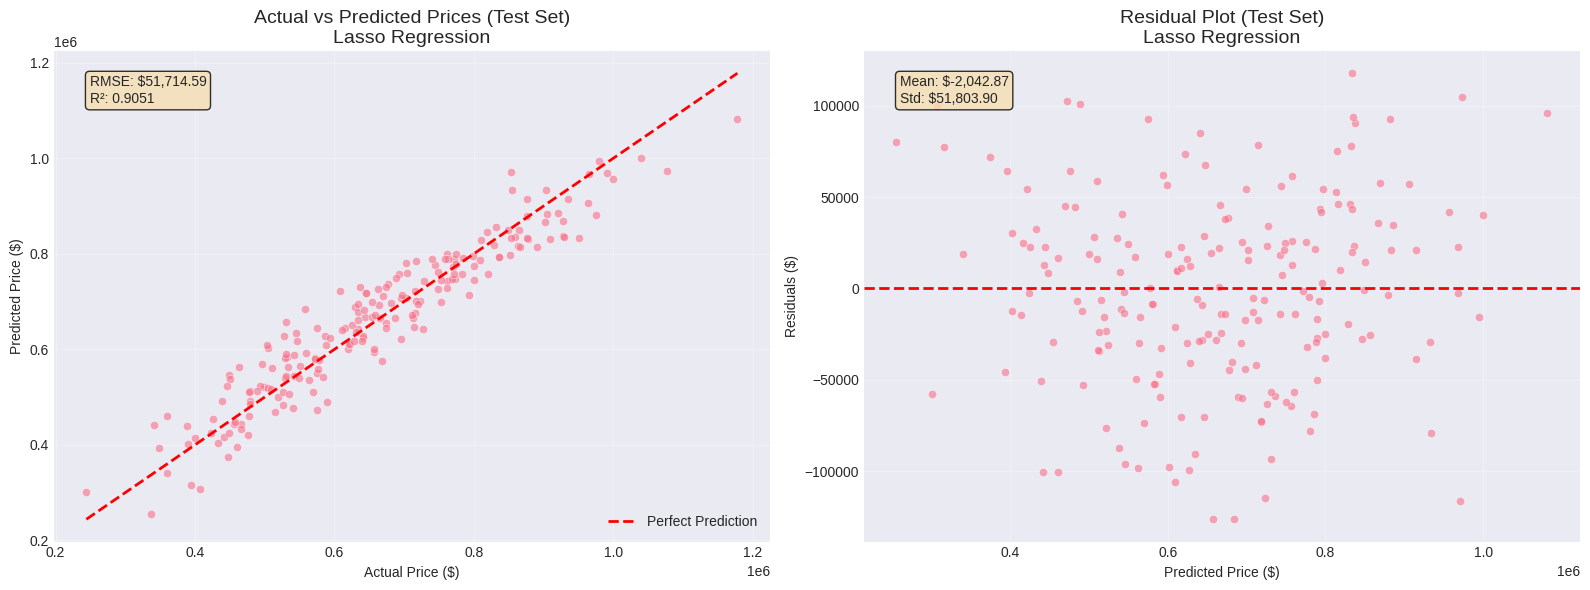

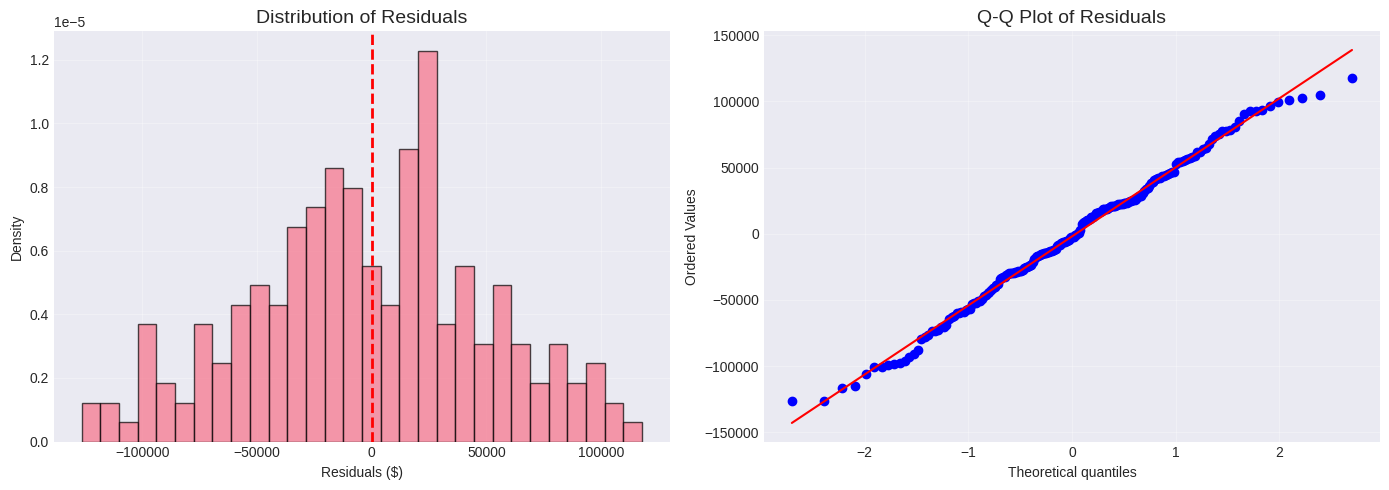

In [26]:
# Cell 11: Prediction Visualization
print("="*60)
print("PREDICTION VISUALIZATION")
print("="*60)

# Get predictions from best model
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 11.1 Actual vs Predicted (Test set)
axes[0].scatter(y_test, y_pred_test, alpha=0.6, edgecolors='w', linewidth=0.5)
# Perfect prediction line
max_val = max(y_test.max(), y_pred_test.max())
min_val = min(y_test.min(), y_pred_test.min())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Actual vs Predicted Prices (Test Set)\n{best_model_name}', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add metrics to plot
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
metrics_text = f'RMSE: ${test_rmse:,.2f}\nR²: {test_r2:.4f}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 11.2 Residual Plot
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.6, edgecolors='w', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title(f'Residual Plot (Test Set)\n{best_model_name}', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Add residual statistics
residual_mean = residuals.mean()
residual_std = residuals.std()
residual_text = f'Mean: ${residual_mean:,.2f}\nStd: ${residual_std:,.2f}'
axes[1].text(0.05, 0.95, residual_text, transform=axes[1].transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 11.3 Distribution of Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of residuals
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7, density=True)
axes[0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Residuals ($)')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Residuals', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Cell 12: Make Predictions on New Data
print("="*60)
print("MAKING PREDICTIONS ON NEW DATA")
print("="*60)

def predict_house_price(model, scaler, label_encoders, input_features):
    """
    Predict house price based on input features

    Parameters:
    -----------
    model : trained model
    scaler : fitted StandardScaler
    label_encoders : dictionary of LabelEncoders
    input_features : dictionary of feature values

    Returns:
    --------
    predicted_price : float
    """
    # Create a dataframe from input
    input_df = pd.DataFrame([input_features])

    # Encode categorical variables
    for col, le in label_encoders.items():
        if col in input_df.columns:
            # Handle unseen labels
            try:
                input_df[col] = le.transform([input_df[col].iloc[0]])
            except ValueError:
                # If label is unseen, use the most common class
                input_df[col] = le.transform([le.classes_[0]])

    # Ensure all columns are present
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0

    # Reorder columns
    input_df = input_df[X.columns]

    # Scale features
    input_scaled = scaler.transform(input_df)

    # Make prediction
    predicted_price = model.predict(input_scaled)[0]

    return predicted_price

# Example 1: Urban luxury house
example_house_1 = {
    'area': 2500,
    'bedrooms': 4,
    'bathrooms': 3,
    'stories': 3,
    'parking': 2,
    'year_built': 2018,
    'location': 'Urban',
    'mainroad': 'Yes',
    'guestroom': 'Yes',
    'basement': 'Yes',
    'furnishingstatus': 'Furnished'
}

# Example 2: Suburban family house
example_house_2 = {
    'area': 1800,
    'bedrooms': 3,
    'bathrooms': 2,
    'stories': 2,
    'parking': 1,
    'year_built': 2005,
    'location': 'Suburban',
    'mainroad': 'Yes',
    'guestroom': 'No',
    'basement': 'No',
    'furnishingstatus': 'Semi-Furnished'
}

# Example 3: Rural small house
example_house_3 = {
    'area': 1200,
    'bedrooms': 2,
    'bathrooms': 1,
    'stories': 1,
    'parking': 0,
    'year_built': 1990,
    'location': 'Rural',
    'mainroad': 'No',
    'guestroom': 'No',
    'basement': 'No',
    'furnishingstatus': 'Unfurnished'
}

examples = [example_house_1, example_house_2, example_house_3]
example_names = ['Urban Luxury House', 'Suburban Family House', 'Rural Small House']

print("🏠 Predicting prices for example houses:\n")

for i, (house, name) in enumerate(zip(examples, example_names), 1):
    predicted_price = predict_house_price(best_model, scaler, label_encoders, house)

    print(f"Example {i}: {name}")
    print("-" * 40)
    for key, value in house.items():
        print(f"  {key:20}: {value}")
    print(f"\n  💰 Predicted Price: ${predicted_price:,.2f}")
    print(f"  💰 Formatted: ${predicted_price:,.0f}")
    print()

MAKING PREDICTIONS ON NEW DATA
🏠 Predicting prices for example houses:

Example 1: Urban Luxury House
----------------------------------------
  area                : 2500
  bedrooms            : 4
  bathrooms           : 3
  stories             : 3
  parking             : 2
  year_built          : 2018
  location            : Urban
  mainroad            : Yes
  guestroom           : Yes
  basement            : Yes
  furnishingstatus    : Furnished

  💰 Predicted Price: $1,170,175.20
  💰 Formatted: $1,170,175

Example 2: Suburban Family House
----------------------------------------
  area                : 1800
  bedrooms            : 3
  bathrooms           : 2
  stories             : 2
  parking             : 1
  year_built          : 2005
  location            : Suburban
  mainroad            : Yes
  guestroom           : No
  basement            : No
  furnishingstatus    : Semi-Furnished

  💰 Predicted Price: $709,593.74
  💰 Formatted: $709,594

Example 3: Rural Small House
------

In [28]:
# Cell 13: Model Saving and Conclusion
print("="*60)
print("MODEL SAVING AND CONCLUSION")
print("="*60)

# Import joblib for saving models
import joblib
import pickle

# Save the best model
model_filename = f'housing_price_model_{best_model_name.replace(" ", "_").lower()}.pkl'
scaler_filename = 'scaler.pkl'
encoders_filename = 'label_encoders.pkl'

# Save model
joblib.dump(best_model, model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save scaler
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved as: {scaler_filename}")

# Save label encoders
with open(encoders_filename, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label encoders saved as: {encoders_filename}")

# Save feature names
feature_names_filename = 'feature_names.pkl'
with open(feature_names_filename, 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print(f"✅ Feature names saved as: {feature_names_filename}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)

print(f"\nDataset Statistics:")
print(f"  • Total samples: {len(df)}")
print(f"  • Number of features: {len(X.columns)}")
print(f"  • Price range: ${df['price'].min():,.0f} to ${df['price'].max():,.0f}")
print(f"  • Average price: ${df['price'].mean():,.0f}")

print(f"\nModel Performance:")
print(f"  • Best model: {best_model_name}")
print(f"  • Test R²: {best_model_metrics['test_r2']:.4f}")
print(f"  • Test RMSE: ${best_model_metrics['test_rmse']:,.2f}")
print(f"  • Cross-Validation R²: {best_model_metrics['cv_mean']:.4f}")

print(f"\nKey Insights:")
# Identify top 3 features
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance = pd.Series(importances, index=X.columns)
    top_features = feature_importance.nlargest(3)
    print(f"  • Top 3 important features:")
    for feat, imp in top_features.items():
        print(f"    - {feat}: {imp:.3f}")
elif hasattr(best_model, 'coef_'):
    coef_abs = pd.Series(np.abs(best_model.coef_), index=X.columns)
    top_features = coef_abs.nlargest(3)
    print(f"  • Top 3 influential features:")
    for feat, coef in top_features.items():
        actual_coef = best_model.coef_[list(X.columns).index(feat)]
        print(f"    - {feat}: {actual_coef:.2f}")

print(f"\nNext Steps:")
print(f"  1. Test the model on new, unseen data")
print(f"  2. Experiment with feature engineering")
print(f"  3. Try hyperparameter tuning for better performance")
print(f"  4. Consider ensemble methods for production")


MODEL SAVING AND CONCLUSION
✅ Model saved as: housing_price_model_lasso_regression.pkl
✅ Scaler saved as: scaler.pkl
✅ Label encoders saved as: label_encoders.pkl
✅ Feature names saved as: feature_names.pkl

SUMMARY

📊 Dataset Statistics:
  • Total samples: 1000
  • Number of features: 11
  • Price range: $244,231 to $1,213,169
  • Average price: $662,461

🎯 Model Performance:
  • Best model: Lasso Regression
  • Test R²: 0.9051
  • Test RMSE: $51,714.59
  • Cross-Validation R²: 0.8981

💡 Key Insights:
  • Top 3 influential features:
    - location: 100521.79
    - bedrooms: 87226.94
    - area: 61709.39

✅ Next Steps:
  1. Test the model on new, unseen data
  2. Experiment with feature engineering
  3. Try hyperparameter tuning for better performance
  4. Consider ensemble methods for production

🎉 Housing Price Prediction Project Completed!
